In [75]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
from collections import namedtuple, deque

# Initialise the environment
env = gym.make("LunarLander-v2", render_mode="human")

# Reset the environment to generate the first observation
observation, info = env.reset(seed=42)
for _ in range(100):
    # this is where you would insert your policy
    action = env.action_space.sample()

    # step (transition) through the environment with the action
    # receiving the next observation, reward and if the episode has terminated or truncated
    observation, reward, terminated, truncated, info = env.step(action)

    # If the episode has ended then we can reset to start a new episode
    if terminated or truncated:
        observation, info = env.reset()

env.close()

In [58]:
ENV_NAME = "LunarLander-v2"
LEARNING_RATE = 0.001
EPISODES = 500
GAMMA = 0.99
EPSILON_START = 1.0
EPSILON_END = 0.01
EPSILON_DECAY = 0.995
BATCH_SIZE = 64
MEMORY_SIZE = 10000
TARGET_UPDATE = 10
epsilon = EPSILON_START

# Neural Network for Q-Learning
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim)
        )

    def forward(self, x):
        return self.fc(x)

In [59]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward','done'))

#the replayMemory Class
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [60]:
def select_action(policy_net,state):
    if random.random()<epsilon:
         action = env.action_space.sample()
         return action
    else:
        state = torch.tensor(state,dtype=torch.float32).unsqueeze(0)
        return policy_net(state).argmax(dim=1).item()

def train_dqn(policy_net,target_net,memory,optimizer):
    if memory.__len__()<BATCH_SIZE:
        return
    sample = memory.sample(BATCH_SIZE)


    batch = Transition(*zip(*sample))

    states = torch.tensor(batch.state,dtype=torch.float32)
    actions = torch.tensor(batch.action,dtype=torch.int64).unsqueeze(1)
    next_states = torch.tensor(batch.next_state,dtype=torch.float32)
    rewards = torch.tensor(batch.reward,dtype=torch.float32)
    dones = torch.tensor(batch.done,dtype=torch.float32)
    

    current_q_values = policy_net(states).gather(1,actions)
    
    next_q_values =  target_net(next_states).max(1)[0].detach()
    target_q_values = rewards +(GAMMA * next_q_values * (1 - dones))

    loss = nn.MSELoss()(current_q_values.squeeze(), target_q_values)
    
    
    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Episode 0, Reward: 94.51148143832992, Epsilon: 0.01
Episode 1, Reward: -32.59437532341552, Epsilon: 0.01
Episode 2, Reward: 152.28290113790374, Epsilon: 0.01
Episode 3, Reward: 139.89618916141754, Epsilon: 0.01
Episode 4, Reward: 234.5110884677816, Epsilon: 0.01
Episode 5, Reward: 113.23081321003109, Epsilon: 0.01
Episode 6, Reward: 187.88004717061466, Epsilon: 0.01
Episode 7, Reward: 107.03070599506127, Epsilon: 0.01
Episode 8, Reward: 114.95807346035555, Epsilon: 0.01
Episode 9, Reward: 103.40121079220653, Epsilon: 0.01
Episode 10, Reward: -1.5432345625724793, Epsilon: 0.01
Episode 11, Reward: 132.69812544320783, Epsilon: 0.01
Episode 12, Reward: 135.00140941366584, Epsilon: 0.01
Episode 13, Reward: -18.56153485631667, Epsilon: 0.01
Episode 14, Reward: 105.09817210206738, Epsilon: 0.01
Episode 15, Reward: 145.8117836981989, Epsilon: 0.01
Episode 16, Reward: 281.46727883954264, Epsilon: 0.01
Episode 17, Reward: 147.17625296547075, Epsilon: 0.01
Episode 18, Reward: 142.31151556142711, 

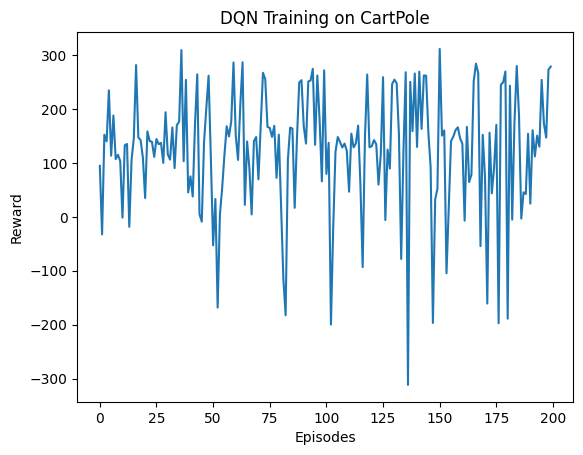

In [71]:
# LEARNING_RATE = 0.0001
# EPISODES = 200
env = gym.make(ENV_NAME)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
trained_model = DQN(state_dim, action_dim)
trained_model.load_state_dict(torch.load("dqn_lunar_lander.pth"))  

policy_net = DQN(state_dim, action_dim)
target_net = DQN(state_dim, action_dim)

target_net.load_state_dict(trained_model.state_dict())
policy_net.load_state_dict(trained_model.state_dict())
target_net.train()

optimizer = optim.Adam(policy_net.parameters(), lr=LEARNING_RATE)
memory = ReplayMemory(MEMORY_SIZE)



rewards = []

for episode in range(EPISODES):
    state = env.reset()[0]
    episode_reward = 0

    for t in range(200):
        action = select_action( policy_net,state)
        next_state, reward, done, truncated, __= env.step(action)
        memory.push(state, action, next_state, reward, done)
        state = next_state
        episode_reward += reward

        train_dqn(policy_net, target_net, memory, optimizer)

        if done or truncated:
            break

    # Decay epsilon
    epsilon = max(EPSILON_END, epsilon * EPSILON_DECAY)
    # Update target network
    if episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

    rewards.append(episode_reward)
    print(f"Episode {episode}, Reward: {episode_reward}, Epsilon: {epsilon:.2f}")

# Save the trained model
torch.save(policy_net.state_dict(), "dqn_lunar_lander.pth")

# Plot rewards
import matplotlib.pyplot as plt
plt.plot(rewards)
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.title('DQN Training on CartPole')
plt.show()

In [74]:
# Testing the Model Performance

env = gym.make("LunarLander-v2",render_mode="human")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

# Load the trained DQN model
policy_net = DQN(state_dim, action_dim)
policy_net.load_state_dict(torch.load("dqn_lunar_lander.pth"))  # Replace with your saved model path
policy_net.eval()  # Set the model to evaluation mode

def play_cartpole(env, policy_net, episodes=5, render=True):
    total_rewards = []

    for episode in range(episodes):
        state = env.reset()[0]
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)  # Add batch dimension
        episode_reward = 0
        done = False
        truncated = False
        while not done and not truncated:
            if render:
                env.render()

            # Use the model to select the best action
            with torch.no_grad():
                q_values = policy_net(state)
                action = torch.argmax(q_values).item()

            # Perform the selected action
            next_state, reward, done, truncated,__= env.step(action)
            episode_reward += reward

            # Update state
            state = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0)

        total_rewards.append(episode_reward)
        print(f"Episode {episode + 1}: Reward = {episode_reward}")

    env.close()
    print(f"Average reward over {episodes} episodes: {np.mean(total_rewards)}")

# Test the trained model
play_cartpole(env, policy_net, episodes=5, render=True)

Episode 1: Reward = -278.42418194674013
Episode 2: Reward = 273.0766151032135
Episode 3: Reward = 274.803680167568
Episode 4: Reward = 170.60746392417073
Episode 5: Reward = 287.7202813665433
Average reward over 5 episodes: 145.55677172295108
